# Simple ViT Training - Matching ResNet Approach

**Fixed**: Frozen backbone now works on MPS!  
**Key**: Freeze BEFORE moving to device

Simple pipeline:
- Simple MLP head
- Basic augmentations  
- BCE loss with pos_weight
- Adam optimizer (lr=1e-3)
- Frozen backbone training

**Goal**: Match ResNet's F1≈0.76

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from pathlib import Path

np.random.seed(2708)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

torch.manual_seed(2708)
if torch.cuda.is_available():
    torch.cuda.manual_seed(2708)
if torch.backends.mps.is_available():
    torch.mps.manual_seed(2708)

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('..')

from dataset import PreprocessedDataset
from models.vit_model import ViTClassifier

print(f"PyTorch: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch: 2.4.0
MPS available: True


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
])

data_root = '../DL_Project_Processed_Data'

train_dataset = PreprocessedDataset(
    root_dir=os.path.join(data_root, 'train'),
    tranform=train_transforms
)

val_dataset = PreprocessedDataset(
    root_dir=os.path.join(data_root, 'val'),
    tranform=None
)

test_dataset = PreprocessedDataset(
    root_dir=os.path.join(data_root, 'test'),
    tranform=None
)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

Train: 1828 | Val: 228 | Test: 229


In [4]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")

Batch size: 32
Train batches: 58


In [5]:
labels_list = []
for _, labels in train_dataset:
    labels_list.append(labels.unsqueeze(0))

all_labels = torch.cat(labels_list, dim=0).float()
pos_counts = all_labels.sum(dim=0)
neg_counts = len(train_dataset) - pos_counts

weights = np.log1p((neg_counts / pos_counts).numpy())
weights = torch.from_numpy(weights).float()

class_names = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']
print("Class weights:")
for i, name in enumerate(class_names):
    print(f"  {name:20s}: {weights[i]:.4f}")

# Move to device AFTER model is ready
weights_device = weights.to(device)

Class weights:
  epidural            : 3.0112
  intraparenchymal    : 1.4084
  intraventricular    : 1.5195
  subarachnoid        : 1.2668
  subdural            : 1.3689


## Model Setup

**Critical**: Freeze backbone BEFORE moving to device!

In [6]:
# Create model (on CPU initially)
model = ViTClassifier(
    model_name='google/vit-base-patch16-224',
    num_classes=5,
    pretrained=True,
    input_channels=9,
    dropout=0.3,
    use_simple_head=True
)

# CRITICAL: Freeze BEFORE moving to device
FREEZE_BACKBONE = True

if FREEZE_BACKBONE:
    model.freeze_backbone()
    print("✓ Backbone frozen (training head + channel adapter only)")
else:
    print("✓ Backbone unfrozen (training full model)")

# NOW move to device
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal params: {total_params/1e6:.1f}M")
print(f"Trainable params: {trainable_params/1e6:.1f}M")

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViT backbone frozen
✓ Backbone frozen (training head + channel adapter only)

Total params: 86.5M
Trainable params: 0.1M


## Test MPS Compatibility

In [7]:
print("Testing MPS with frozen backbone...")
print("="*60)

model.train()
test_images, test_labels = next(iter(train_loader))
test_images = test_images.to(device)
test_labels = test_labels.to(device).float()

# Forward
test_outputs = model(test_images)
print(f"✓ Forward: {test_outputs.shape}")

# Backward
criterion_test = nn.BCEWithLogitsLoss()
loss = criterion_test(test_outputs, test_labels)
loss.backward()
print(f"✓ Backward: loss={loss.item():.4f}")

print("="*60)
print("✓✓✓ MPS WORKS WITH FROZEN BACKBONE! ✓✓✓")
print("="*60)

Testing MPS with frozen backbone...
✓ Forward: torch.Size([32, 5])
✓ Backward: loss=0.8395
✓✓✓ MPS WORKS WITH FROZEN BACKBONE! ✓✓✓


In [8]:
criterion = nn.BCEWithLogitsLoss(pos_weight=weights_device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

print("Training setup:")
print("  Loss: BCEWithLogitsLoss")
print("  Optimizer: Adam (lr=1e-3, wd=1e-6)")
print("  Early stopping: patience=10")

Training setup:
  Loss: BCEWithLogitsLoss
  Optimizer: Adam (lr=1e-3, wd=1e-6)
  Early stopping: patience=10


In [9]:
def train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=10):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        
        for images, labels in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device).float()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            train_correct += (preds == labels).sum().item()
        
        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / (len(train_loader.dataset) * 5)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images)
                val_loss += criterion(outputs, labels).item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / (len(val_loader.dataset) * 5)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1} | Train: {train_loss:.4f}/{train_acc:.4f} | Val: {val_loss:.4f}/{val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(best_model_state)
            break
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [10]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
checkpoint_dir = f"checkpoints/simple_vit_{timestamp}"
Path(checkpoint_dir).mkdir(parents=True, exist_ok=True)

print(f"Training on {device} with frozen backbone...")
print(f"Checkpoint: {checkpoint_dir}\n")

train_losses, train_accuracies, val_losses, val_accuracies = train_validate_model(
    model, train_loader, val_loader, criterion, optimizer, 100, device, patience=10
)

print("\nTraining completed!")

Training on mps with frozen backbone...
Checkpoint: checkpoints/simple_vit_20251020_211815



[Train] Epoch 1: 100%|██████████| 58/58 [01:36<00:00,  1.67s/it]


Epoch 1 | Train: 0.7751/0.5779 | Val: 0.6706/0.6868


[Train] Epoch 2: 100%|██████████| 58/58 [01:31<00:00,  1.58s/it]


Epoch 2 | Train: 0.6225/0.7347 | Val: 0.5809/0.7789


[Train] Epoch 3: 100%|██████████| 58/58 [01:31<00:00,  1.58s/it]


Epoch 3 | Train: 0.5657/0.7835 | Val: 0.5426/0.7947


[Train] Epoch 4: 100%|██████████| 58/58 [01:30<00:00,  1.57s/it]


Epoch 4 | Train: 0.5508/0.7957 | Val: 0.5509/0.7860


[Train] Epoch 5: 100%|██████████| 58/58 [03:06<00:00,  3.22s/it]


Epoch 5 | Train: 0.5615/0.7772 | Val: 0.5555/0.7789


[Train] Epoch 6: 100%|██████████| 58/58 [05:19<00:00,  5.50s/it]


Epoch 6 | Train: 0.5377/0.7976 | Val: 0.5396/0.7807


[Train] Epoch 7: 100%|██████████| 58/58 [01:30<00:00,  1.55s/it]


Epoch 7 | Train: 0.5322/0.7958 | Val: 0.5401/0.7807


[Train] Epoch 8: 100%|██████████| 58/58 [01:30<00:00,  1.57s/it]


Epoch 8 | Train: 0.5420/0.7916 | Val: 0.5254/0.8000


[Train] Epoch 9: 100%|██████████| 58/58 [01:32<00:00,  1.59s/it]


Epoch 9 | Train: 0.5203/0.8036 | Val: 0.5426/0.7781


[Train] Epoch 10: 100%|██████████| 58/58 [01:25<00:00,  1.47s/it]


Epoch 10 | Train: 0.5327/0.7989 | Val: 0.5387/0.7746


[Train] Epoch 11: 100%|██████████| 58/58 [01:35<00:00,  1.64s/it]


Epoch 11 | Train: 0.5285/0.7978 | Val: 0.5665/0.7781


[Train] Epoch 12: 100%|██████████| 58/58 [01:30<00:00,  1.56s/it]


Epoch 12 | Train: 0.5548/0.7871 | Val: 0.5848/0.7912


[Train] Epoch 13: 100%|██████████| 58/58 [01:28<00:00,  1.53s/it]


Epoch 13 | Train: 0.5506/0.7950 | Val: 0.5879/0.7605


[Train] Epoch 14: 100%|██████████| 58/58 [01:27<00:00,  1.51s/it]


Epoch 14 | Train: 0.5494/0.7888 | Val: 0.5709/0.7868


[Train] Epoch 15: 100%|██████████| 58/58 [01:31<00:00,  1.58s/it]


Epoch 15 | Train: 0.5531/0.7863 | Val: 0.5693/0.7702


[Train] Epoch 16: 100%|██████████| 58/58 [01:28<00:00,  1.53s/it]


Epoch 16 | Train: 0.5642/0.7881 | Val: 0.5922/0.7737


[Train] Epoch 17: 100%|██████████| 58/58 [01:28<00:00,  1.53s/it]


Epoch 17 | Train: 0.5739/0.7852 | Val: 0.5434/0.7886


[Train] Epoch 18: 100%|██████████| 58/58 [01:26<00:00,  1.49s/it]


Epoch 18 | Train: 0.5564/0.7871 | Val: 0.5531/0.7763
Early stopping at epoch 18

Training completed!


In [11]:
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
}, f'{checkpoint_dir}/best_model.pt')

print(f"Model saved: {checkpoint_dir}/best_model.pt")

Model saved: checkpoints/simple_vit_20251020_211815/best_model.pt


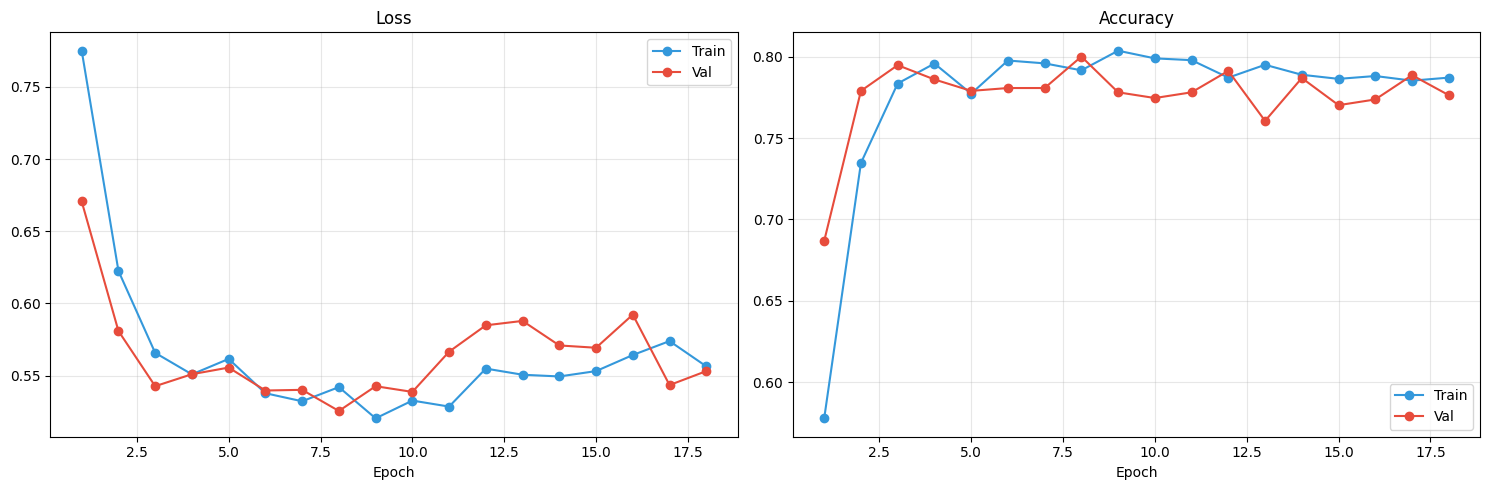

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
epochs = range(1, len(train_losses) + 1)

axes[0].plot(epochs, train_losses, 'o-', label='Train', color='#3498db')
axes[0].plot(epochs, val_losses, 'o-', label='Val', color='#e74c3c')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, train_accuracies, 'o-', label='Train', color='#3498db')
axes[1].plot(epochs, val_accuracies, 'o-', label='Val', color='#e74c3c')
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{checkpoint_dir}/training_history.png', dpi=150)
plt.show()


Generating ROC curves for all 7 classes...
Saved ROC curves to: checkpoints/simple_vit_20251020_211815/roc_curves_all_classes.png


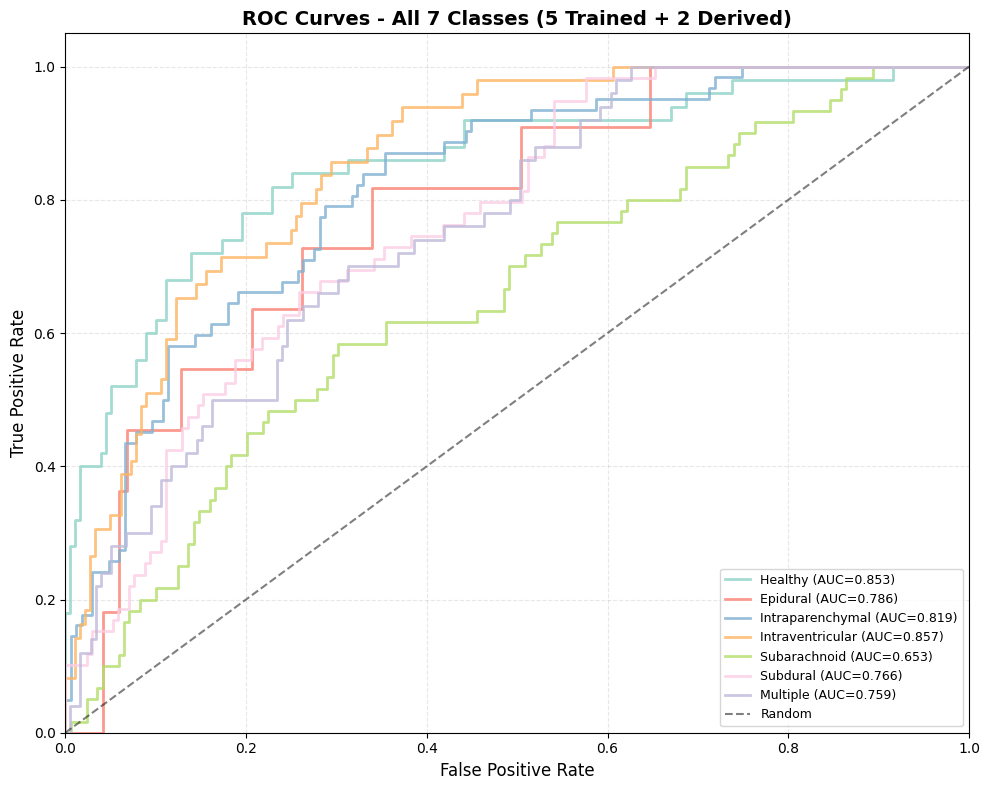


AUC-ROC values for each class:
--------------------------------------------------
Healthy             : 0.8532
Epidural            : 0.7857
Intraparenchymal    : 0.8193
Intraventricular    : 0.8571
Subarachnoid        : 0.6528
Subdural            : 0.7663
Multiple            : 0.7592
--------------------------------------------------


In [13]:
# Plot ROC Curves for all 7 classes (5 trained + 2 derived)
print("\nGenerating ROC curves for all 7 classes...")

from sklearn.metrics import roc_curve, auc as compute_auc
import matplotlib.pyplot as plt

# Get probabilities from test set
model.eval()
all_probs = []
all_targets = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)
        all_targets.append(labels.numpy())

all_probs = np.concatenate(all_probs, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Compute derived classes
healthy_targets = (all_targets.sum(axis=1) == 0).astype(int)
multiple_targets = (all_targets.sum(axis=1) > 1).astype(int)

# Compute probabilities for derived classes
healthy_probs = np.prod(1 - all_probs, axis=1)
prob_none = np.prod(1 - all_probs, axis=1)
prob_exactly_one = sum([all_probs[:, i] * np.prod(1 - np.delete(all_probs, i, axis=1), axis=1) 
                        for i in range(5)])
multiple_probs = 1 - prob_none - prob_exactly_one

# All 7 classes (5 trained + 2 derived)
class_names_roc = ['Healthy', 'Epidural', 'Intraparenchymal', 'Intraventricular', 'Subarachnoid', 'Subdural', 'Multiple']
all_targets_list = [healthy_targets] + [all_targets[:, i] for i in range(5)] + [multiple_targets]
all_probs_list = [healthy_probs] + [all_probs[:, i] for i in range(5)] + [multiple_probs]
colors = ['#8dd3c7', '#fb8072', '#80b1d3', '#fdb462', '#b3de69', '#fccde5', '#bebada']

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

for name, targets, probs, color in zip(class_names_roc, all_targets_list, all_probs_list, colors):
    if len(np.unique(targets)) > 1:
        fpr, tpr, _ = roc_curve(targets, probs)
        roc_auc = compute_auc(fpr, tpr)
        ax.plot(fpr, tpr, color=color, lw=2, alpha=0.8, label=f'{name} (AUC={roc_auc:.3f})')

# Add diagonal line for random classifier
ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random')

# Formatting
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - All 7 Classes (5 Trained + 2 Derived)', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()

# Save the plot
roc_path = f'{checkpoint_dir}/roc_curves_all_classes.png'
plt.savefig(roc_path, dpi=150, bbox_inches='tight')
print(f"Saved ROC curves to: {roc_path}")
plt.show()

# Print AUC values for each class
print("\nAUC-ROC values for each class:")
print("-" * 50)
for name, targets, probs in zip(class_names_roc, all_targets_list, all_probs_list):
    if len(np.unique(targets)) > 1:
        fpr, tpr, _ = roc_curve(targets, probs)
        roc_auc = compute_auc(fpr, tpr)
        print(f"{name:20s}: {roc_auc:.4f}")
    else:
        print(f"{name:20s}: N/A (only one class present)")
print("-" * 50)
